In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

%matplotlib inline

In [52]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df.info()
print('----------------------')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare      

去掉无用的列

In [53]:
train_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
test_df.drop(['Name', 'Ticket'], axis=1, inplace=True)

## Embarked分析

Port of Embarkation

- C = Cherbourg
- Q = Queenstown
- S = Southampton

查看NaN值，把它们填充为‘S'（出现次数最多）

In [54]:
print('Embarked value counts:', train_df['Embarked'].value_counts(), sep='\r\n')

display(train_df[~train_df["Embarked"].isin(['S', 'C', 'Q'])])

train_df['Embarked'].fillna('S', inplace=True)

print('Embarked value counts:', train_df['Embarked'].value_counts(), sep='\r\n')

Embarked value counts:
S    644
C    168
Q     77
Name: Embarked, dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
61,1,1,female,38.0,0,0,80.0,B28,NaN
829,1,1,female,62.0,0,0,80.0,B28,NaN


Embarked value counts:
S    646
C    168
Q     77
Name: Embarked, dtype: int64


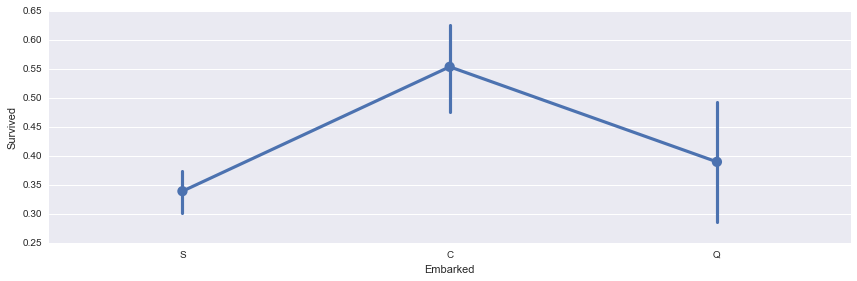

In [45]:
sns.factorplot('Embarked', 'Survived', data=train_df, size=4, aspect=3)

plt.show()